In [7]:
import os
dist_path = '/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/'
latest_point_path = os.path.join(dist_path, 'results/test5000.pkl')
train_bs = 1

In [8]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as Func
from dgl.nn import CuGraphGATConv, GATConv, GraphConv
from dgl.nn.functional import edge_softmax
from dgl.utils import expand_as_pair
from dgl.nn.pytorch.utils import Identity
from dgl import function as fn
from dgl.base import DGLError

device = 'cuda:0'


class Envelope(nn.Module):  # bessel扩展计算式子

    def __init__(self, exponent):
        super(Envelope, self).__init__()

        self.p = exponent + 1
        self.a = -(self.p + 1) * (self.p + 2) / 2
        self.b = self.p * (self.p + 2)
        self.c = -self.p * (self.p + 1) / 2

    def forward(self, x):

        x_p_0 = x.pow(self.p)
        x_p_1 = x_p_0 * x
        x_p_2 = x_p_1 * x
        env_val = x + self.a * x_p_0 + self.b * x_p_1 + self.c * x_p_2

        return env_val


class BesselBasisLayer(nn.Module): # bessel扩展

    def __init__(self,
                 num_radial,
                 cutoff = 20.,
                 envelope_exponent = 6,):
        super(BesselBasisLayer, self).__init__()

        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)
        self.frequencies = nn.Parameter(torch.Tensor(num_radial))
        self.reset_params()

    def reset_params(self):
         
         self.frequencies.data = torch.arange(1., self.frequencies.numel() + 1.
                     ).mul_(np.pi)

    def forward(self, d):

        d_scaled = d / self.cutoff
        d_cutoff = self.envelope(d_scaled)
        d_sin = d_cutoff * torch.sin(self.frequencies * d_scaled)
        return d_sin
    

class MLP(nn.Module):

    def __init__(self, dim_list, activation, dropout=False):
        super(MLP, self).__init__()
        
        self.num_layers = len(dim_list) - 1
        self.activation = activation
        self.layers = nn.ModuleList()

        for i in range(self.num_layers):
            self.layers.append(nn.Linear(dim_list[i], dim_list[i+1])).to(device)
        
        if dropout:
            self.layers.append(nn.Dropout(p=0.1)).to(device)
            self.num_layers += 1

    def forward(self, x):

        for i in range(self.num_layers - 1):
            x = self.activation(self.layers[i](x))

        return self.layers[-1](x)


class GATv2Conv(nn.Module):# (batch问题在这里)
    def __init__(
        self,
        in_feats,
        out_feats,
        num_heads,
        feat_drop=0.0,
        attn_drop=0.0,
        negative_slope=0.2,
        bessel_cutoff = 4.,
        bessel_exponent = 6,
        residual=False,
        activation=None,
        allow_zero_in_degree=False,
        bias=True,
        share_weights=False,
    ):
        super(GATv2Conv, self).__init__()
        self._num_heads = num_heads
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        self._allow_zero_in_degree = allow_zero_in_degree
        if isinstance(in_feats, tuple):
            self.fc_src = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=bias
            )
            self.fc_dst = nn.Linear(
                self._in_dst_feats, out_feats * num_heads, bias=bias
            )
        else:
            self.fc_src = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=bias
            )
            if share_weights:
                self.fc_dst = self.fc_src
            else:
                self.fc_dst = nn.Linear(
                    self._in_src_feats, out_feats * num_heads, bias=bias
                )
        self.attn = nn.Parameter(torch.DoubleTensor(size=(1, num_heads, out_feats)))
        self.feat_drop = nn.Dropout(feat_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        self.prelu = nn.PReLU(num_heads)
        self.leaky_relu = nn.LeakyReLU(negative_slope)
        self.bessel = BesselBasisLayer(num_heads, bessel_cutoff, bessel_exponent)
        if residual:
            if self._in_dst_feats != out_feats * num_heads:
                self.res_fc = nn.Linear(
                    self._in_dst_feats, num_heads * out_feats, bias=bias
                )
            else:
                self.res_fc = Identity()
        else:
            self.register_buffer("res_fc", None)
        self.activation = activation
        self.share_weights = share_weights
        self.bias = bias
        
        self.reset_parameters()

    def reset_parameters(self):
        
        gain = nn.init.calculate_gain("relu")
        nn.init.xavier_normal_(self.fc_src.weight, gain=gain)
        if self.bias:
            nn.init.constant_(self.fc_src.bias, 0)
        if not self.share_weights:
            nn.init.xavier_normal_(self.fc_dst.weight, gain=gain)
            if self.bias:
                nn.init.constant_(self.fc_dst.bias, 0)
        nn.init.xavier_normal_(self.attn, gain=gain)
        if isinstance(self.res_fc, nn.Linear):
            nn.init.xavier_normal_(self.res_fc.weight, gain=gain)
            if self.bias:
                nn.init.constant_(self.res_fc.bias, 0)


    def set_allow_zero_in_degree(self, set_value):
        self._allow_zero_in_degree = set_value

    def forward(self, graph, feat, get_attention=False):
        
        with graph.local_scope():
            if not self._allow_zero_in_degree:
                if (graph.in_degrees() == 0).any():
                    raise DGLError()

            if isinstance(feat, tuple):
                h_src = self.feat_drop(feat[0])
                h_dst = self.feat_drop(feat[1])
                feat_src = self.fc_src(h_src).view(
                    -1, self._num_heads, self._out_feats
                )
                feat_dst = self.fc_dst(h_dst).view(
                    -1, self._num_heads, self._out_feats
                )
            else:
                h_src = h_dst = self.feat_drop(feat)
                feat_src = self.fc_src(h_src).view(
                    -1, self._num_heads, self._out_feats
                )
                if self.share_weights:
                    feat_dst = feat_src
                else:
                    feat_dst = self.fc_dst(h_dst).view(
                        -1, self._num_heads, self._out_feats
                    )
                if graph.is_block:
                    feat_dst = feat_dst[: graph.number_of_dst_nodes()]
                    h_dst = h_dst[: graph.number_of_dst_nodes()]

            coeff = self.bessel(graph.edata['distance'].reshape([-1, 1])).unsqueeze(-1)
            
            graph.srcdata.update(
                {"el": feat_src}
            )  # (num_src_edge, num_heads, out_dim)
            graph.dstdata.update({"er": feat_dst})
            graph.apply_edges(fn.u_add_v("el", "er", "e"))

            e = self.prelu(
                graph.edata.pop("e") * coeff
            )  # (num_src_edge, num_heads, out_dim)

            e = (
                (e * self.attn).sum(dim=-1).unsqueeze(dim=2)
            )  # (num_edge, num_heads, 1)
            # compute softmax
            
            graph.edata["a"] = self.attn_drop(
                edge_softmax(graph, e)
            )  # (num_edge, num_heads)
            # message passing

            graph.update_all(fn.u_mul_e("el", "a", "m"), fn.sum("m", "ft"))
            rst = graph.dstdata["ft"]
            # print(graph.edata["a"])
            # residual
            if self.res_fc is not None:
                resval = self.res_fc(h_dst).view(
                    h_dst.shape[0], -1, self._out_feats
                )
                rst = rst + resval
            # activation
            if self.activation:
                rst = self.activation(rst)

            if get_attention:
                return rst, graph.edata["a"]
            else:
                return rst
        
class OrbitalNN(nn.Module):  # 扩展为轨道特征
    def __init__(self, orb_dim_list, activation = nn.LeakyReLU()):
        super(OrbitalNN, self).__init__()

        self.orb_dim_list = orb_dim_list
        self.activation = activation

        self.mlp_list = [MLP(orb_dim_list, activation) for i in range(10)]
    
    def forward(self, feats):

        temp_feat = []
        for i in range(10):
            temp_feat.append(self.mlp_list[i](feats))

        return torch.cat(temp_feat, dim=0)


class OnsiteNN(nn.Module): # 从轨道特征变成在位能

    def __init__(self, onsite_dim_list, activation = nn.LeakyReLU()):
        super(OnsiteNN, self).__init__()

        self.onsite_mlp = [MLP(onsite_dim_list, activation) for i in range(10)]

    def forward(self, ofeat, onsite_key, onsite_num):
        '''
        onsite_key 0: 原子序号：代表第几个原子 0 1 2
                   1: 轨道相互作用轨道序号（暂未使用）
                   2: 轨道序号
                   3: onsite矩阵的位置
        ''' 
        onsite = torch.zeros(onsite_num).to(device)

        for i in range(onsite_key[0].size):
            onsite[onsite_key[2][i]] = self.onsite_mlp[onsite_key[1][i]](ofeat[onsite_key[0]][i])
        
        return onsite.flatten()



class HoppingNN(nn.Module): # 从轨道特征生成Slater Koster参量

    def __init__(self,
                 hopping_dim_list1,
                 hopping_dim_list2,
                 is_orb = [1,1,1,1],
                 activation = nn.LeakyReLU()):
        super(HoppingNN, self).__init__()

        # atom features to orbital features (s and p orbitals)

        self.activation = activation
        self.is_orb = is_orb
        self.hopping_dim_list1 = hopping_dim_list1
        self.hopping_dim_list2 = hopping_dim_list2

        self.smlp = MLP([hopping_dim_list1[0]] + hopping_dim_list1[1:], activation)
        self.Smlp = MLP([hopping_dim_list1[0]] + hopping_dim_list1[1:], activation)
        self.pmlp = MLP([hopping_dim_list1[0] * 3] + hopping_dim_list1[1:], activation)
        self.dmlp = MLP([hopping_dim_list1[0] * 5] + hopping_dim_list1[1:], activation)

        self.mlp_list = [MLP(hopping_dim_list2, activation) for i in range(14)]

    def forward(self, feat, feats, hopping_index, atom_num, orb_key, d, ex_d, orb1_index, orb2_index):

 
        if self.is_orb[0]:
            sfeat = torch.zeros((atom_num, self.hopping_dim_list1[-1])).to(device)
            sfeat[orb1_index[0]] = self.smlp(feats[orb2_index[0]])

        if self.is_orb[1]:
            pfeat = torch.zeros((atom_num, self.hopping_dim_list1[-1])).to(device)
            for oin1, oin2 in zip(orb1_index[1], orb2_index[1]):
                pfeat[oin1] = self.pmlp(feats[oin2].flatten())

        if self.is_orb[2]:
            dfeat = torch.zeros((atom_num, self.hopping_dim_list1[-1])).to(device)
            for oin1, oin2 in zip(orb1_index[2], orb2_index[2]):
                dfeat[oin1] = self.dmlp(feats[oin2].flatten()) 

        if self.is_orb[3]:
            Sfeat = torch.zeros((atom_num, self.hopping_dim_list1[-1])).to(device)
            Sfeat[orb1_index[3]] = self.Smlp(feats[orb2_index[3]])

        # 合并成s S p d 轨道特征

        atom1, atom2 = hopping_index[:,0], hopping_index[:,1]

        np.save('/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/batch4in.npy', d.cpu().detach().numpy())
        
        zeros = torch.zeros((atom1.shape[0],1)).to(device)
    
        if orb_key[0]: # Vsss
            vfeat = self.mlp_list[0](torch.cat([sfeat[atom1]/(d**2),sfeat[atom2]/(d**2),ex_d], 1))
        else:
            vfeat = zeros
        if orb_key[1]: # Vsps
            vfeat = torch.cat((vfeat, self.mlp_list[1](torch.cat([sfeat[atom1]/(d**2), pfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)

        if orb_key[2]: # Vpps
            vfeat = torch.cat((vfeat, self.mlp_list[2](torch.cat([pfeat[atom1]/(d**2), pfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)

        if orb_key[3]: # Vppp
            vfeat = torch.cat((vfeat, self.mlp_list[3](torch.cat([pfeat[atom1]/(d**2), pfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)

        if orb_key[4]: # Vsds
            vfeat = torch.cat((vfeat, self.mlp_list[4](torch.cat([sfeat[atom1]/(d**2), dfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)

        if orb_key[5]: # Vpds
            vfeat = torch.cat((vfeat, self.mlp_list[5](torch.cat([pfeat[atom1]/(d**2), dfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)

        if orb_key[6]: # Vpdp
            vfeat = torch.cat((vfeat, self.mlp_list[6](torch.cat([pfeat[atom1]/(d**2), dfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)

        if orb_key[7]: # Vdds
            vfeat = torch.cat((vfeat, self.mlp_list[7](torch.cat([dfeat[atom1]/(d**2), dfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)
        
        if orb_key[8]: # Vddp
            vfeat = torch.cat((vfeat, self.mlp_list[8](torch.cat([dfeat[atom1]/(d**2), dfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)
        
        if orb_key[9]: # Vddd
            vfeat = torch.cat((vfeat, self.mlp_list[9](torch.cat([dfeat[atom1]/(d**2), dfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)
        
        if orb_key[10]: # VSSs
            vfeat = torch.cat((vfeat, self.mlp_list[10](torch.cat([Sfeat[atom1]/(d**2), Sfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)
        
        if orb_key[11]: # VSss
            vfeat = torch.cat((vfeat, self.mlp_list[11](torch.cat([Sfeat[atom1]/(d**2), sfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)
        
        if orb_key[12]: # VSps
            vfeat = torch.cat((vfeat, self.mlp_list[12](torch.cat([Sfeat[atom1]/(d**2), pfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)
        
        if orb_key[13]: # VSds
            vfeat = torch.cat((vfeat, self.mlp_list[13](torch.cat([Sfeat[atom1]/(d**2), dfeat[atom2]/(d**2),ex_d], 1))),-1)
        else:
            vfeat = torch.cat((vfeat, zeros),-1)

        np.save('/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/batch4out.npy', vfeat.cpu().detach().numpy())
        
        return vfeat


    
class GraphNN(nn.Module):

    def __init__(self,
                dim_list,
                head_list,
                norm = 'both', 
                weight = True, 
                num_heads = 5,
                bias = True, 
                activation = nn.LeakyReLU(),
                ):  
        super(GraphNN, self).__init__()
        
        self.num_layers = len(dim_list) - 1
        self.layers = nn.ModuleList()
        head_list = [1] + head_list
        residual = True
        # residual = False
        negative_slope = 0.5
        share_weights = False

        for i in range(self.num_layers - 1):
           self.layers.append(GATv2Conv(in_feats = dim_list[i] * head_list[i], out_feats = dim_list[i+1], num_heads = head_list[i+1], residual = residual, negative_slope = negative_slope, bias = bias, activation = activation, share_weights = share_weights)).to(device)
           
        self.layers.append(GATv2Conv(in_feats = dim_list[-2]*head_list[-2], out_feats = dim_list[-1], num_heads = head_list[-1], residual = residual, negative_slope = negative_slope, bias = bias, activation = None, share_weights = share_weights)).to(device)


    def forward(self, g, inputs):
        # print(g, inputs.shape)
        
        for i in range(self.num_layers-1) :
            # print(g, i, inputs.shape)
            inputs = self.layers[i](g, inputs).flatten(1)
            
        return self.layers[-1](g, inputs).mean(1)


class WHOLEMODEL(nn.Module):

    def __init__(self,
                  embedding_dim,
                  graph_dim,
                  gnn_dim_list,
                  gnn_head_list,
                  orb_dim_list,
                  onsite_dim_list,
                  hopping_dim_list1,
                  hopping_dim_list2,
                  expander_bessel_dim,
                  expander_bessel_cutoff,
                  atom_num,
                  is_orb = [1,1,1,1],
                  expander_bessel_exponent = 6,
                  orbital_activation = nn.LeakyReLU(negative_slope=0.38),
                  onsite_activation = nn.LeakyReLU(negative_slope=0.38), 
                  hopping_activation = nn.LeakyReLU(negative_slope=0.38),): 
        
        super(WHOLEMODEL, self).__init__()
        
        self.atomic_init_dim = gnn_dim_list[0]
        self.embedding_dim = embedding_dim
        self.graph_dim = graph_dim
        self.atom_num = atom_num

        self.atomic_feat = nn.Embedding(120, self.embedding_dim) 

        self.gnn = GraphNN(gnn_dim_list, gnn_head_list)
        self.orbnn = OrbitalNN(orb_dim_list, orbital_activation)
        # self.onn = OnsiteNN(onsite_dim_list, onsite_num, onsite_activation)
        self.onn = OnsiteNN(onsite_dim_list, onsite_activation)
        # self.hnn = HoppingNN(hopping_dim_list1, hopping_dim_list2, hopping_activation)
        self.hnn = HoppingNN(hopping_dim_list1, hopping_dim_list2, is_orb, hopping_activation)
        self.expander = BesselBasisLayer(expander_bessel_dim, expander_bessel_cutoff, expander_bessel_exponent)
        self.cutoff = expander_bessel_cutoff
        
    def forward(self, bg, para_sk, is_hopping, hopping_index, orb_key, d, onsite_key, cell_atom_num, onsite_num, orb1_index, orb2_index):

        featstable = bg.ndata['feature'][:, :self.graph_dim]
        if self.embedding_dim > 0:
            featembedding = self.atomic_feat(bg.ndata["species"]).reshape([-1,self.embedding_dim])
            featall = torch.cat((featstable, featembedding), dim=1)
        else:
            featall = featstable

        feat = self.gnn(bg, featall) 

    # o = self.onn(feat[:cell_atom_num])
        feato = self.orbnn(feat)

        o = self.onn(feat, onsite_key, onsite_num)
        # h = self.hnn(feat, hopping_index, d, self.expander(d), orb_key)
        h = self.hnn(feat, feato, hopping_index, self.atom_num, orb_key, d, self.expander(d), orb1_index, orb2_index)

        hsk = torch.sum(h*para_sk, dim=1)
        hsk[torch.where(is_hopping==0)[0]] = o
          
        return hsk, feat, feato, featall, o, h


In [9]:
import numpy as np
import torch
import torch.nn as nn
import random
import utils
import numpy as np
import time
import json
import os
from batch import GGCNNDATASET
from dgl.dataloading import GraphDataLoader
from dgl import batch
import warnings
 
warnings.filterwarnings('ignore')  # 忽略所有警告

device = 'cuda:0'

seed = 1 # seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) # 让显卡产生的随机数一致
torch.cuda.manual_seed_all(seed) # 多卡模式下，让所有显卡生成的随机数一致？这个待验证
np.random.seed(seed) # numpy产生的随机数一致
random.seed(seed) # python产生的随机数一致

# CUDA中的一些运算，如对sparse的CUDA张量与dense的CUDA张量调用torch.bmm()，它通常使用不确定性算法。
# 为了避免这种情况，就要将这个flag设置为True，让它使用确定的实现。
torch.backends.cudnn.deterministic = True

# 设置这个flag可以让内置的cuDNN的auto-tuner自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题。
# 但是由于噪声和不同的硬件条件，即使是同一台机器，benchmark都可能会选择不同的算法。为了消除这个随机性，设置为 False
torch.backends.cudnn.benchmark = False

torch.set_default_dtype(torch.float64)

train_data_path = os.path.join(dist_path,'datas/train_data')
test_data_path = os.path.join(dist_path,'datas/test_data')
config_json_file = os.path.join(dist_path, 'datas/config.json')
if not os.path.exists(os.path.join(dist_path, 'results')):
    os.makedirs(os.path.join(dist_path, 'results'), exist_ok=True)

with open(config_json_file, 'r', encoding='utf-8') as f:
    config_para = json.load(f)

# configure hyper parameters
train_num      = config_para['train_num']
test_num       = config_para['test_num']
train_reload   = config_para['train_reload']
test_reload    = config_para['test_reload']
batch_size     = config_para['batch_size']
num_epoch      = config_para['num_epoch']
lr_radio_init  = config_para['lr_radio_init']
lr_factor      = config_para['lr_factor']
lr_patience    = config_para['lr_patience']
lr_verbose     = config_para['lr_verbose']
lr_threshold   = config_para['lr_threshold']
lr_eps         = config_para['lr_eps']
min_lr         = config_para['min_lr']
cooldown       = config_para['cooldown']
is_sch         = config_para['is_sch']
is_save        = config_para['is_save']
save_frequncy  = config_para['save_frequncy']

is_L1          = config_para['is_L1']
is_L2          = config_para['is_L2']
L1_radio       = config_para['L1_radio']
L2_radio       = config_para['L2_radio']

reset_all        = config_para['reset_all']
reset_model      = config_para['reset_model']
reset_model_path = config_para['model_path']
reset_opt        = config_para['reset_opt']
reset_sch        = config_para['reset_sch']

# configure trainingset path
trainset_rawdata_path = os.path.join(train_data_path, 'raw')
trainset_dgldata_path = os.path.join(train_data_path, 'dgl')

# configure trainingset path
testset_rawdata_path = os.path.join(test_data_path, 'raw')
testset_dgldata_path = os.path.join(test_data_path, 'dgl')

# configure network structure
embedding_dim          = config_para['embedding_dim']
graph_dim              = config_para['graph_dim']
gnn_dim_list           = config_para['gnn_dim_list']
gnn_head_list          = config_para['gnn_head_list']
onsite_dim_list        = config_para['onsite_dim_list']
orb_dim_list           = config_para['orb_dim_list']
hopping_dim_list1      = config_para['hopping_dim_list1']
hopping_dim_list2      = config_para['hopping_dim_list2']
expander_bessel_dim    = config_para['expander_bessel_dim']
expander_bessel_cutoff = config_para['expander_bessel_cutoff']
atom_num               = config_para['atom_num']
is_orb                 = config_para['is_orb']

gnn_dim_list[0] = embedding_dim + graph_dim

utils.seed_torch(seed = 24)

trainset, traininfos = utils.get_data(
                                        raw_dir = trainset_rawdata_path, 
                                        save_dir = trainset_dgldata_path,
                                        data_num = train_num, 
                                        force_reload = train_reload,
                                        )

traingraphs, trainlabels, init_dim = trainset.get_all()
# traingraphs = batch(traingraphs)
# traingraphs = traingraphs.to(device)
train_dataloader = GraphDataLoader(trainset, batch_size = train_bs, drop_last = False, shuffle = False)

with open(os.path.join(dist_path, 'train_infos.txt'), 'w+') as file:
    for i in traininfos.values():
        file.write(i['filename'] + '\n')

testset, testinfos = utils.get_data(
                                    raw_dir = testset_rawdata_path, 
                                    save_dir = testset_dgldata_path, 
                                    data_num = test_num,
                                    force_reload = test_reload,
                                    )

testgraphs, testlabels, init_dim = testset.get_all()
# testgraphs = batch(testgraphs)
# testgraphs = testgraphs.to(device)
test_dataloader = GraphDataLoader(testset, batch_size = 1, drop_last = False, shuffle = False)

with open(os.path.join(dist_path, 'test_infos.txt'), 'w+') as file:
    for i in testinfos.values():
        file.write(i['filename'] + '\n')

model = WHOLEMODEL(
                    embedding_dim = embedding_dim,
                    graph_dim = graph_dim,
                    gnn_dim_list = gnn_dim_list,
                    gnn_head_list = gnn_head_list,
                    orb_dim_list = orb_dim_list,
                    onsite_dim_list = onsite_dim_list,
                    hopping_dim_list1 = hopping_dim_list1,
                    hopping_dim_list2 = hopping_dim_list2,
                    expander_bessel_dim = expander_bessel_dim,
                    expander_bessel_cutoff = expander_bessel_cutoff,
                    atom_num=atom_num*train_bs,
                    is_orb = is_orb
                    )

model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr_radio_init, eps=lr_eps)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=lr_factor, patience=lr_patience*int(train_num / batch_size), verbose=lr_verbose, threshold=lr_threshold, threshold_mode='rel', cooldown=cooldown*int(train_num / batch_size), min_lr=min_lr, eps=lr_eps)

print(lr_patience*int(train_num / batch_size))

criterion = nn.SmoothL1Loss()
loss_per_epoch = np.zeros(int(train_num / train_bs))  
losses = np.zeros(num_epoch)
test_losses = np.zeros(num_epoch)

if os.path.exists(latest_point_path) and not reset_all:
    checkpoint = torch.load(latest_point_path)
    if not reset_model:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        checkpoint = torch.load(reset_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    if not reset_opt:
        opt.load_state_dict(checkpoint['optimizer_state_dict'])
    if not reset_sch:
        sch.load_state_dict(checkpoint['scheduler_state_dict'])
    loss = checkpoint['loss']
    start_epoch = checkpoint['epoch']
    print('Load epoch {} succeed！'.format(start_epoch))
    if os.path.exists(os.path.join(dist_path, 'results/losses.npy')):
        losses = np.load(os.path.join(dist_path, 'results/losses.npy'))
        if num_epoch > losses.size:
            losses = np.concatenate((losses, np.zeros(num_epoch - losses.size)))
        print('Load train loss succed！')
    else:
        losses = np.zeros(num_epoch)
    if os.path.exists(os.path.join(dist_path, 'results/test_losses.npy')):
        test_losses = np.load(os.path.join(dist_path, 'results/test_losses.npy'))
        if num_epoch > test_losses.size:
            test_losses = np.concatenate((test_losses, np.zeros(num_epoch - test_losses.size)))
        print('Load test loss succed！')
    else:
        test_losses = np.zeros(num_epoch)
else:
    start_epoch = 0
    losses = np.zeros(num_epoch)
    test_losses = np.zeros(num_epoch)
    print('Can not load saved model!Training from beginning!')

para_sk, hopping_index, hopping_info, d, is_hopping, onsite_key, cell_atom_num, onsite_num, orb1_index, orb2_index, orb_num, rvectors, rvectors_all, tensor_E, tensor_eikr, orb_key, filename = utils.batch_index(train_dataloader, traininfos, train_bs)


1
1
1
1
1
200
Load epoch 5000 succeed！
Load train loss succed！
Load test loss succed！


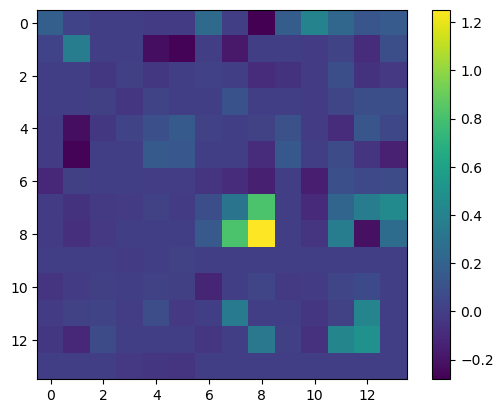

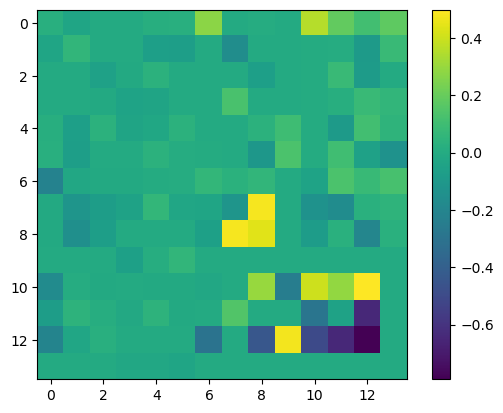

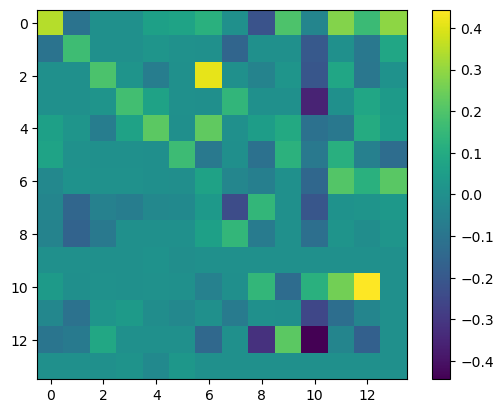

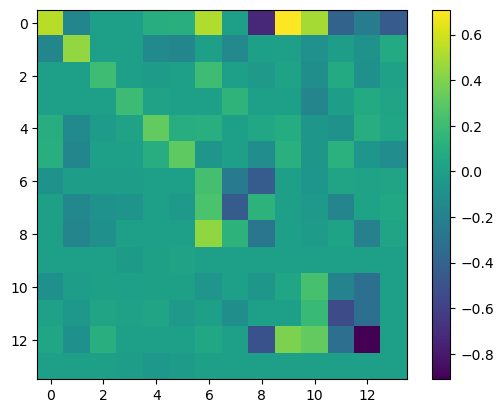

Epoch 05001 | Train_Loss 0.012027 | Learning_rate 0.001000
trainging OK!


In [14]:
import matplotlib.pyplot as plt
import networkx as nx

sss = []
# kkk = []
for epoch in range(start_epoch + 1, start_epoch + 2):
    for graphs, labels in train_dataloader:
        loss = 0
        i = int(labels[0] / train_bs)

        # kkk.append(graphs.edata['distance'].cpu())

        # def draw_dgl_graph(graph):
        #     # 将DGL图转换为networkx图
        #     nx_graph = graph.to_networkx()

        #     # 绘制networkx图
        #     nx.draw(nx_graph, with_labels=True)

        #     # 显示图形
        #     plt.show()
            
        # draw_dgl_graph(graphs.cpu())

        # print(graphs)
        hsk, feat, feato, featall, o, h = model(graphs, para_sk[i], is_hopping[i], hopping_index[i], orb_key[i], d[i], onsite_key[i], cell_atom_num[i], onsite_num[i].sum(), orb1_index[i], orb2_index[i])
        
        # print(d[i].flatten())
        # pltd.append(d[i].flatten().cpu().detach().numpy())
        # if (i+1)%4 == 0:
        #     plt.plot(np.concatenate(pltd))
        #     plt.show()

        b1 = int(hsk.shape[0] / len(labels))
        b2 = int(hopping_info[i].shape[0] / len(labels))
        b3 = int(orb_num[i].shape[0] / len(labels))
        b4 = int(cell_atom_num[i] / len(labels))

        # kkk.append(d[i])
        for j in range(len(labels)):
            sss.append(d[i][j * 980:(j + 1)*980])
            # print(featall[j * 15:(j + 1 )*15])
            HR = utils.construct_hr(hsk[j * b1:(j + 1) * b1], hopping_info[i][j * b2:(j + 1) * b2], orb_num[i][j * b3:(j + 1) * b3], b4, rvectors[i][j])
            reproduced_bands = utils.compute_bands(HR, tensor_eikr[i][j])
            loss += criterion(reproduced_bands[:, 4:12], tensor_E[i][j][:, 4:12])
            reproduced_band = reproduced_bands.cpu().detach().numpy()[:, 4:12]

            reference_bands = tensor_E[i][j].cpu().detach().numpy()[:, 4:12]

            # plt.imshow(feato[j * 15:(j + 1 )*15].cpu().detach().numpy(), aspect='auto')
            # plt.colorbar()

            # f = plt.gcf()  #获取当前图像
            # f.savefig('/media/pigz2538/E2BCC52DBCC4FCD3/Users/z2538/Desktop/111/MoS2-test8/feats.png')
            # plt.show()
            plt.imshow(HR[0].cpu().detach().numpy())
            plt.colorbar()
            plt.show()

            # for k in range(reproduced_band.shape[1]):
            #     plt.plot(reference_bands[:,k],color = 'r')
            #     plt.plot(reproduced_band[:,k],color = 'b', ls=':')

            # plt.xlabel('k')
            # plt.ylabel('eV')
            # plt.legend(['DFT', 'TBGAT'])
            # # plt.savefig('/home/pigz2538/桌面/20240330/' + predict_name[:-5] + '-4090.png')
            # plt.show()

        if is_L1:
            L1 = 0
            for name,param in model.named_parameters():
                if 'bias' not in name:
                    L1 += torch.norm(param, p=1) * L1_radio
            loss += L1

        if is_L2:
            L2 = 0
            for name,param in model.named_parameters():
                if 'bias' not in name:
                    L2 += torch.norm(param, p=2) * L2_radio
            loss += L2
        
        if is_sch:
            sch.step(loss)

        loss_per_epoch[i] = loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()
    # print(loss_per_epoch)
    # print(test_loss)
    losses[epoch - 1] = loss_per_epoch.sum() / train_num
    current_lr = opt.param_groups[0]['lr']

    print("Epoch {:05d} | Train_Loss {:.6f} | Learning_rate {:.6f}" . format(epoch, losses[epoch - 1], current_lr))

    if epoch % save_frequncy == 0 and is_save:

        check_point = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'scheduler_state_dict': sch.state_dict(),
                'loss': loss
                }
        torch.save(check_point, os.path.join(dist_path, 'results/test{}.pkl'.format(epoch)))
        
        torch.save(check_point, latest_point_path)

        np.save(os.path.join(dist_path,'results/losses.npy'), losses)
        np.save(os.path.join(dist_path,'results/test_losses.npy'), test_losses)

print('trainging OK!')

In [29]:
batch1in = np.load('/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/batch1in.npy')
batch1out = np.load('/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/batch1out.npy')
batch4in = np.load('/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/batch4in.npy')
batch4out = np.load('/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/batch4out.npy')

batch4in.shape
# batch1out.shape
# batch4out[2940:]-batch1out
# orb2_indexs[0][1]
# orb2_indexk[0][1]
s = batch4in[2940:]-batch1in
s
# d4[0][:] - d1[3]
# batch1out[:,0]
# batch4out[:, 0]

ValueError: operands could not be broadcast together with shapes (0,1) (980,1) 

In [ ]:
d1[1] - d4[0][980:1960]

tensor([[-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.0094],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.2534],
        [-0.

In [ ]:
kkk

[tensor([ -7.4597,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          -5.3149,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          -8.7348,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         -13.0381,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         -12.7598,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          -3.1231,  -8.7043,   0.0000,   0.0000,   0.0000,   0.0000,  -4.6886,
           0.0000,   0.0000,   0.0000,   0.0000,  20.3012,   0.0000,   0.0000,
           0.0000,   0.0000, -11.8034,  -8.6950,   0.0000,   0.0000,   0.0000,
           0.0000,  -4.8134,   0.0000,   0.0000,   0.0000,   0.0000,  18.0668,
           0.0000,   0.0000,   0.0000,   0.0000, -12.0952], device='cuda:0',
        grad_fn=<CopySlices>),
 tensor([ -2.4078,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          -1.4331,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          -7.2243,   0.

In [ ]:
class Envelope(nn.Module):  # bessel扩展计算式子

    def __init__(self, exponent):
        super(Envelope, self).__init__()

        self.p = exponent + 1
        self.a = -(self.p + 1) * (self.p + 2) / 2
        self.b = self.p * (self.p + 2)
        self.c = -self.p * (self.p + 1) / 2

    def forward(self, x):

        x_p_0 = x.pow(self.p)
        x_p_1 = x_p_0 * x
        x_p_2 = x_p_1 * x
        env_val = x + self.a * x_p_0 + self.b * x_p_1 + self.c * x_p_2

        return env_val
    
class BesselBasisLayer(nn.Module): # bessel扩展

    def __init__(self,
                 num_radial,
                 cutoff = 20.,
                 envelope_exponent = 6,):
        super(BesselBasisLayer, self).__init__()

        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)
        self.frequencies = nn.Parameter(torch.Tensor(num_radial))
        self.reset_params()

    def reset_params(self):
         
         self.frequencies.data = torch.arange(1., self.frequencies.numel() + 1.
                     ).mul_(np.pi)

    def forward(self, d):

        d_scaled = d / self.cutoff
        d_cutoff = self.envelope(d_scaled)
        d_sin = d_cutoff * torch.sin(self.frequencies * d_scaled)
        # print(self.frequencies, d_cutoff.shape, d_scaled.shape, d_sin.shape)
        return d_sin

In [ ]:
expander = BesselBasisLayer(4, 20, 6).to(device)

In [ ]:
ex = torch.tensor([1.1,2.2,3.3,4.4]).to(device)
d1 = torch.tensor([1.55,5.1446,6.212,9.6868]).to(device)
d2 = torch.tensor([8.8668,2.13,3.445,1.78]).to(device)
d3 = torch.tensor([7.82,8.123,2.45785,4.4545]).to(device)
d4 = torch.tensor([6.12,5.5457,7.785,9.545]).to(device)

dfull = torch.cat([d1,d2,d3,d4]).to(device)
a = expander(dfull.reshape(-1,1)).unsqueeze(-1)
b = expander(d4.reshape(-1,1)).unsqueeze(-1)
a[12:] - b
# c = ex * d
# c
# c.unsqueeze(-1)

tensor([[[0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
a = torch.tensor([[1,2,3,4],[4,3,2,1]])
b = torch.tensor([[6,7,8,9],[8,9,7,6],[1,2,3,4],[4,3,2,1]])

temp_feat = []
for i in range(10):
    temp_feat.append(a)

d = torch.cat(temp_feat, dim=-1)

In [ ]:
d

tensor([[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4,
         1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
        [4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1,
         4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1]])